# Setup

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from torch.cuda import amp
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import os, shutil, json
from PIL import Image

import math
import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_curve, roc_auc_score, confusion_matrix,
    ConfusionMatrixDisplay, precision_score, recall_score, f1_score, balanced_accuracy_score
)

In [3]:
# #Xác định đường dẫn checkpoint
# checkpoint_dir = "/kaggle/working/checkpoints"

# # Kiểm tra và xóa
# if os.path.exists(checkpoint_dir):
#     shutil.rmtree(checkpoint_dir)
#     print(f"Đã xóa toàn bộ thư mục: {checkpoint_dir}")
# else:
#     print(f"Thư mục không tồn tại: {checkpoint_dir}")

# Data Preprocess

Tổng số lớp: 7490
count    7490.000000
mean        5.310147
std         0.988418
min         4.000000
25%         5.000000
50%         5.000000
75%         6.000000
max         7.000000
Name: count, dtype: float64
label
0     5
1     5
2     4
3     5
4     4
5     5
6     5
7     7
8     6
9     5
10    6
11    7
12    5
13    4
14    4
15    6
16    5
17    6
18    4
19    5
Name: count, dtype: int64


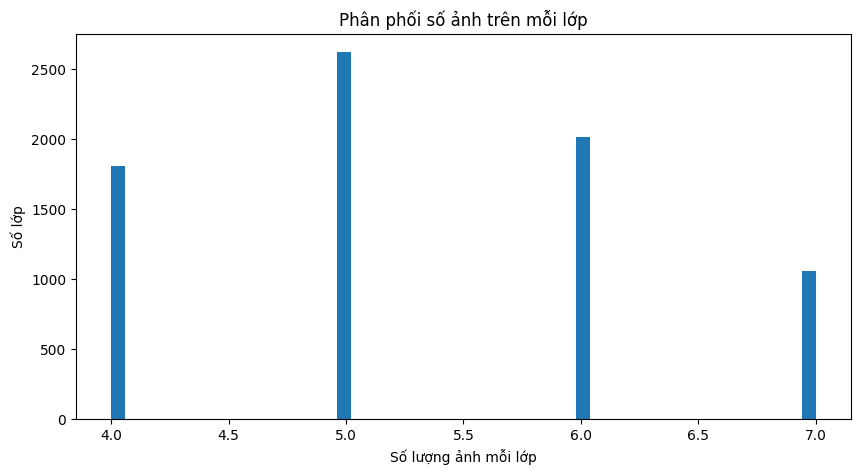

In [4]:
# Đọc file dataset
df = pd.read_csv("/kaggle/input/triplet-celeba-fr-dataset/triplet_celebA_fr_dataset.csv")

# Đếm số lượng ảnh mỗi lớp
label_counts = df['label'].value_counts().sort_index()

print("Tổng số lớp:", len(label_counts))
print(label_counts.describe())
print(label_counts.head(20))  # xem 20 lớp đầu

# Vẽ histogram
plt.figure(figsize=(10,5))
plt.hist(label_counts, bins=50)
plt.xlabel("Số lượng ảnh mỗi lớp")
plt.ylabel("Số lớp")
plt.title("Phân phối số ảnh trên mỗi lớp")
plt.show()

Số ảnh thuộc label 0: 5
[1] /kaggle/input/celeba-face-recognition-triplets/CelebA FR Triplets/CelebA FR Triplets/images/024091.jpg | Tồn tại: True
[2] /kaggle/input/celeba-face-recognition-triplets/CelebA FR Triplets/CelebA FR Triplets/images/111433.jpg | Tồn tại: True
[3] /kaggle/input/celeba-face-recognition-triplets/CelebA FR Triplets/CelebA FR Triplets/images/056279.jpg | Tồn tại: True
[4] /kaggle/input/celeba-face-recognition-triplets/CelebA FR Triplets/CelebA FR Triplets/images/108998.jpg | Tồn tại: True
[5] /kaggle/input/celeba-face-recognition-triplets/CelebA FR Triplets/CelebA FR Triplets/images/000023.jpg | Tồn tại: True


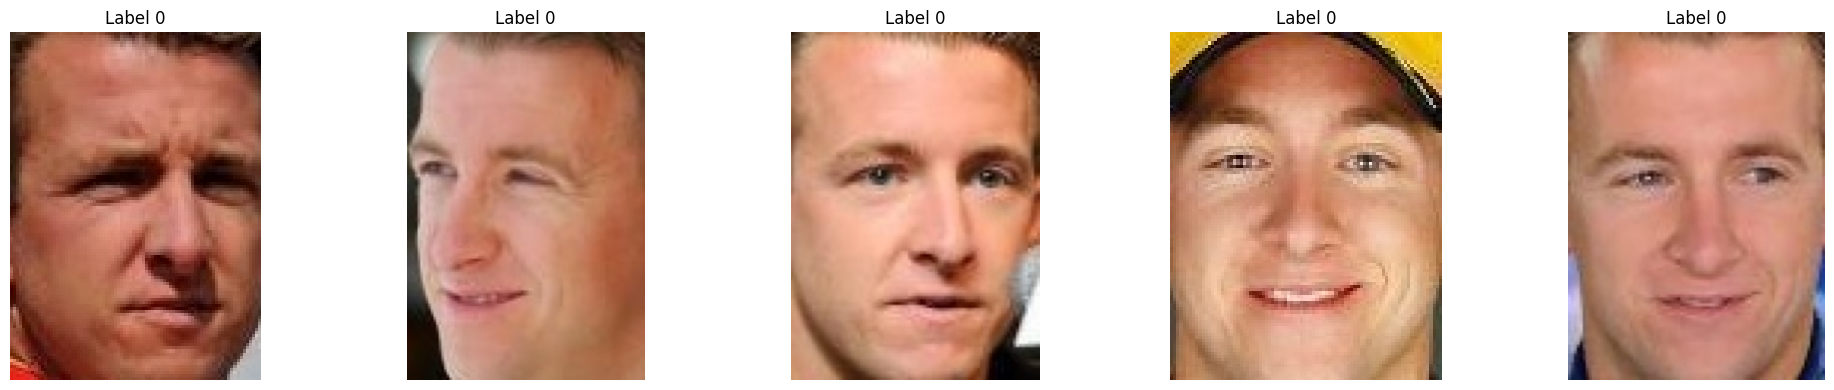

In [5]:
df = pd.read_csv("/kaggle/input/triplet-celeba-fr-dataset/triplet_celebA_fr_dataset.csv")
df.columns = df.columns.str.strip().str.lower()

first_label = df['label'].unique()[0]
subset = df[df['label'] == first_label]
print(f"Số ảnh thuộc label {first_label}:", len(subset))

if len(subset) == 0:
    print("⚠️ Không có ảnh nào thuộc label này!")
else:
    for i, row in enumerate(subset.itertuples(), start=1):
        path = getattr(row, 'image_path')
        print(f"[{i}] {path} | Tồn tại: {os.path.exists(path)}")

    # Hiển thị ảnh nếu tồn tại
    n = len(subset)
    fig, axes = plt.subplots(1, n, figsize=(4 * n, 4))

    if n == 1:
        axes = [axes]

    for ax, (_, row) in zip(axes, subset.iterrows()):
        path = row['image_path']
        if os.path.exists(path):
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax.imshow(img)
        else:
            ax.text(0.5, 0.5, "Không tìm thấy ảnh", ha="center", va="center")
        ax.axis("off")
        ax.set_title(f"Label {first_label}")

    plt.tight_layout()
    plt.show()

# Model base

In [6]:
class ResNetFeatureExtractor(nn.Module):
    def __init__(self, backbone_name='resnet50', in_features=2048, output_dim=512, pretrained=True):
        super().__init__()

        assert backbone_name == 'resnet50', "This version supports only resnet50"

        # Load ResNet
        resnet = models.resnet50(pretrained=pretrained)

        # Delete Connected Layer
        resnet.fc = nn.Identity()
        self.backbone = resnet
        
        if output_dim != in_features:
            self.fc = nn.Linear(in_features, output_dim)
        else:
            self.fc = nn.Identity()

    def forward(self, x):
        x = self.backbone(x)  # Output shape: (Batch, 2048)
        x = self.fc(x)
        return x

In [7]:
class ArcMarginProduct(nn.Module):
    def __init__(self, in_features, out_features, s=30.0, m=0.50, easy_margin=False):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features    # kích thước embedding đầu vào
        self.out_features = out_features  # số lớp (số người)
        self.s = s                        # scale factor
        self.m = m                        # angular margin

        # Trọng số cho mỗi lớp
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        # precompute constants
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

        self.easy_margin = easy_margin

    def forward(self, input, label):
        # normalize feature và weight
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))

        # thêm margin vào góc
        phi = cosine * self.cos_m - sine * self.sin_m

        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)

        # tạo one-hot cho label
        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)

        # thay giá trị cos(theta) của class đúng bằng cos(theta + m)
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s  # scale để ổn định gradient

        return output  # đầu ra dùng cho CrossEntropyLoss

In [8]:
class ArcFaceModel(nn.Module):
    def __init__(self, num_classes, feature_dim=512, scale=16.0, margin=0.25):
        super().__init__()
        self.feature_extractor = ResNetFeatureExtractor(
            backbone_name='resnet50',
            output_dim=feature_dim,
        )
        self.dropout = nn.Dropout(p=0.5)
        
        if num_classes is not None:
            self.margin_head = ArcMarginProduct(feature_dim, num_classes, s=scale, m=margin)
        else:
            self.margin_head = None  # dùng khi chỉ extract embedding

    def forward(self, x, labels=None):
        # lấy feature từ backbone
        features = self.feature_extractor(x)
        features = self.dropout(features)
        embeddings = F.normalize(features, p=2, dim=1)

        if labels is not None:
            logits = self.margin_head(embeddings, labels)
            return logits, embeddings  # dùng trong training
        else:
            return embeddings

# Data Loader

In [9]:
class FaceDataset(Dataset):
    def __init__(self, df, transform=None, label_to_idx=None):
        self.data = df.reset_index(drop=True)
        self.transform = transform

        # Chuyển label từ string sang index (ví dụ '001' -> 0, '002' -> 1, ...)
        if label_to_idx is not None:
            self.label_to_idx = label_to_idx
        else:
            self.label_to_idx = {label: idx for idx, label in enumerate(sorted(self.data['label'].unique()))}
        self.idx_to_label = {idx: label for label, idx in self.label_to_idx.items()}
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['image_path']
        label_str = self.data.iloc[idx]['label']
        label = self.label_to_idx[label_str]

        # Đọc ảnh
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

In [10]:
train_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(112, scale=(0.9, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                         std=[0.5, 0.5, 0.5]),
])

test_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

csv_path = "/kaggle/input/triplet-celeba-fr-dataset/triplet_celebA_fr_dataset.csv"
df = pd.read_csv(csv_path)

In [11]:
all_labels = sorted(df['label'].unique())
label_to_idx_global = {lab: i for i, lab in enumerate(all_labels)}

In [12]:
unique_labels = df['label'].unique()
train_ids, temp_ids = train_test_split(unique_labels, test_size=0.2, random_state=42)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)

train_df = df[df['label'].isin(train_ids)]
val_df = df[df['label'].isin(val_ids)]
test_df = df[df['label'].isin(test_ids)]

print(f"Train: {len(train_df)} ảnh, Val: {len(val_df)} ảnh, Test: {len(test_df)} ảnh")
print(f"Train labels: {train_df['label'].nunique()} | Val labels: {val_df['label'].nunique()} | Test labels: {test_df['label'].nunique()}")

Train: 31833 ảnh, Val: 3966 ảnh, Test: 3974 ảnh
Train labels: 5992 | Val labels: 749 | Test labels: 749


In [13]:
train_dataset = FaceDataset(train_df, transform=train_transform, label_to_idx=label_to_idx_global)
val_dataset   = FaceDataset(val_df,   transform=test_transform,  label_to_idx=label_to_idx_global)
test_dataset  = FaceDataset(test_df,  transform=test_transform,  label_to_idx=label_to_idx_global)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, num_workers=4)

In [14]:
images, labels = next(iter(train_loader))
print("Batch images:", images.shape)
print("Batch labels:", labels[:10])

print("train labels unique count:", len(train_dataset.label_to_idx))
print("val labels unique count:", len(val_dataset.label_to_idx))
print("test labels unique count:", len(test_dataset.label_to_idx))

Batch images: torch.Size([32, 3, 112, 112])
Batch labels: tensor([1635, 4568, 3582, 7186, 5325, 7413, 3538, 4000, 2332, 6021])
train labels unique count: 7490
val labels unique count: 7490
test labels unique count: 7490


# Training Phase

In [15]:
@torch.no_grad()
def evaluate_verification(model, val_loader, device):
    model.eval()
    embeddings = []
    labels = []

    for images, lbls in tqdm(val_loader, desc="Extracting embeddings", leave=False):
        images = images.to(device)
        _, emb = model(images, lbls.to(device))
        embeddings.append(emb.cpu())
        labels.append(lbls)

    embeddings = F.normalize(torch.cat(embeddings), dim=1)
    labels = torch.cat(labels)

    # --- Compute pairwise cosine similarity ---
    sims, gts = [], []
    n = len(labels)
    for i in range(0, n - 1):
        for j in range(i + 1, n):
            sims.append(F.cosine_similarity(embeddings[i], embeddings[j], dim=0).item())
            gts.append(1 if labels[i] == labels[j] else 0)

    sims = np.array(sims)
    gts = np.array(gts)

    # --- ROC-AUC ---
    roc_auc = roc_auc_score(gts, sims)

    # --- Compute EER ---
    thresholds = np.linspace(-1, 1, 200)
    fprs, fnrs = [], []
    for th in thresholds:
        preds = (sims > th).astype(int)
        fp = np.sum((preds == 1) & (gts == 0))
        fn = np.sum((preds == 0) & (gts == 1))
        tp = np.sum((preds == 1) & (gts == 1))
        tn = np.sum((preds == 0) & (gts == 0))

        fpr = fp / (fp + tn + 1e-8)
        fnr = fn / (tp + fn + 1e-8)
        fprs.append(fpr)
        fnrs.append(fnr)

    fprs, fnrs = np.array(fprs), np.array(fnrs)
    eer_idx = np.argmin(np.abs(fprs - fnrs))
    eer = (fprs[eer_idx] + fnrs[eer_idx]) / 2
    best_th = thresholds[eer_idx]

    return {"roc_auc": roc_auc, "eer": eer, "best_th": best_th}

In [16]:
def train_model(model, train_loader, val_loader, optimizer, device, num_epochs, loss_fn, checkpoint_dir, early_stop=None, start_epoch=0):
    os.makedirs(checkpoint_dir, exist_ok=True)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )
    scaler = amp.GradScaler()
    best_eer = float("inf")
    epochs_no_improve = 0

    for epoch in range(start_epoch, num_epochs):
        model.train()
        running_loss, total = 0.0, 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}", leave=True)

        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            with amp.autocast():
                logits, _ = model(images, labels)
                loss = loss_fn(logits, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * images.size(0)
            total += images.size(0)
            progress_bar.set_postfix({"train_loss": f"{running_loss / total:.4f}"})

        avg_train_loss = running_loss / total

        # --- Validation phase ---
        metrics = evaluate_verification(model, val_loader, device)
        val_eer = metrics["eer"]
        roc_auc = metrics["roc_auc"]

        scheduler.step(val_eer)

        print(f"\nEpoch [{epoch}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | "
              f"Val EER: {val_eer:.4f} | ROC-AUC: {roc_auc:.4f} | LR: {scheduler.get_last_lr()[0]:.2e}")

        # --- Save best model ---
        if best_eer is None and val_eer < best_eer:
            best_eer = val_eer
            best_model_path = os.path.join(checkpoint_dir, "best_model.pt")
            torch.save({
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "best_eer": best_eer,
                "scheduler_state_dict": scheduler.state_dict(),
            }, best_model_path)
            print(f"Best model updated at epoch {epoch} (EER={val_eer:.4f})")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        # ---- SAVE CHECKPOINT ----
        checkpoint_path = os.path.join(checkpoint_dir, f"epoch_{epoch}.pt")
        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "best_eer": best_eer,
            "scheduler_state_dict": scheduler.state_dict(),
        }, checkpoint_path)
        
        if early_stop and epochs_no_improve >= early_stop:
            print(f"Early stopping at epoch {epoch}")
            break

    return model, best_eer

# Train model

In [17]:
df = pd.read_csv("/kaggle/input/triplet-celeba-fr-dataset/triplet_celebA_fr_dataset.csv")
num_classes = df["label"].nunique()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_fn = nn.CrossEntropyLoss()

model = ArcFaceModel(num_classes=num_classes)
model = torch.nn.DataParallel(model).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-5, weight_decay=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 172MB/s] 


In [18]:
checkpoint_path = "/kaggle/working/checkpoints/best_model.pt"
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
model.load_state_dict(checkpoint["model_state_dict"])
current_epoch = checkpoint["epoch"]
best_eer = checkpoint["best_eer"]

print(f'Model at epoch {current_epoch} have EER: {best_eer:.5f}')

Model at epoch 28 have EER: 0.09815


In [ ]:
trained_model, best_val_loss = train_model(
    model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=70,
    loss_fn=loss_fn,
    checkpoint_dir='/kaggle/working/checkpoints',
    early_stop=7,
    start_epoch=current_epoch+1
)

# Test model

In [23]:
print("✅ Loaded best_model.pt successfully for evaluation or inference.")

model.eval()
metrics = evaluate_verification(model, test_loader, device)
print(f"Test EER: {metrics['eer']:.4f} | ROC-AUC: {metrics['roc_auc']:.4f} | Thresholds: {metrics['best_th']:.4f}")

✅ Loaded best_model.pt successfully for evaluation or inference.


Test EER: 0.1054 | ROC-AUC: 0.9489


In [42]:
@torch.no_grad()
def evaluate_verification_plot(model, val_loader, device):
    model.eval()
    embeddings, labels = [], []

    print("🔍 Extracting embeddings from model...")
    for images, lbls in tqdm(val_loader, desc="Embedding", leave=False):
        images = images.to(device)
        _, emb = model(images, lbls.to(device))
        embeddings.append(emb.cpu())
        labels.append(lbls)

    embeddings = F.normalize(torch.cat(embeddings), dim=1)
    labels = torch.cat(labels)

    print("📊 Computing pairwise similarities...")
    sims, gts = [], []
    n = len(labels)
    for i in range(0, n - 1):
        for j in range(i + 1, n):
            sims.append(F.cosine_similarity(embeddings[i], embeddings[j], dim=0).item())
            gts.append(1 if labels[i] == labels[j] else 0)

    sims = np.array(sims)
    gts = np.array(gts)

    # --- ROC & AUC ---
    fpr, tpr, thresholds = roc_curve(gts, sims)
    roc_auc = roc_auc_score(gts, sims)

    # --- EER ---
    fnr = 1 - tpr
    eer_idx = np.nanargmin(np.abs(fpr - fnr))
    eer = (fpr[eer_idx] + fnr[eer_idx]) / 2
    best_th = thresholds[eer_idx]

    # --- TPR @ FPR = 1e-3 ---
    fpr_target = 1e-3
    idx = np.searchsorted(fpr, fpr_target)
    tpr_at_fpr = tpr[idx] if idx < len(tpr) else 0.0

    # --- Confusion Matrix (với ngưỡng EER) ---
    y_pred = (sims >= best_th).astype(int)
    cm = confusion_matrix(gts, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Different", "Same"])

    # --- Precision, Recall, F1 ---
    precision = precision_score(gts, y_pred)
    recall = recall_score(gts, y_pred)
    f1 = f1_score(gts, y_pred)
    balanced_acc = balanced_accuracy_score(gts, y_pred)

    # --- Visualization ---
    fig, ax = plt.subplots(1, 3, figsize=(16, 5))

    # ROC Curve
    ax[0].plot(fpr, tpr, label=f"AUC={roc_auc:.4f}")
    ax[0].plot([0, 1], [0, 1], 'k--')
    ax[0].set_xlabel("False Positive Rate")
    ax[0].set_ylabel("True Positive Rate")
    ax[0].set_title("ROC Curve (Face Verification)")
    ax[0].legend()

    # DET Curve
    ax[1].plot(fpr, fnr, label=f"EER={eer:.4f}")
    ax[1].set_xlabel("False Positive Rate")
    ax[1].set_ylabel("False Negative Rate")
    ax[1].set_title("DET Curve")
    ax[1].legend()

    # Confusion Matrix
    disp.plot(ax=ax[2], cmap=plt.cm.Blues, colorbar=False)
    ax[2].set_title(f"Confusion Matrix (thr={best_th:.4f})")

    plt.tight_layout()
    plt.show()

    # --- Print results ---
    print(f"✅ ROC-AUC: {roc_auc:.4f}")
    print(f"✅ EER: {eer:.4f} (threshold={best_th:.4f})")
    print(f"✅ TPR@FPR=1e-3: {tpr_at_fpr:.4f}")
    print(f"✅ Precision: {precision:.4f}")
    print(f"✅ Recall: {recall:.4f}")
    print(f"✅ F1-score: {f1:.4f}")
    print(f"✅ Balanced Accuracy: {balanced_acc:.4f}")

    return {
        "roc_auc": roc_auc,
        "eer": eer,
        "best_threshold": best_th,
        "tpr_at_fpr=1e-3": tpr_at_fpr,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "balanced_acc": balanced_acc,
        "roc_curve": (fpr, tpr),
        "det_curve": (fpr, fnr)
    }

🔍 Extracting embeddings from model...


📊 Computing pairwise similarities...


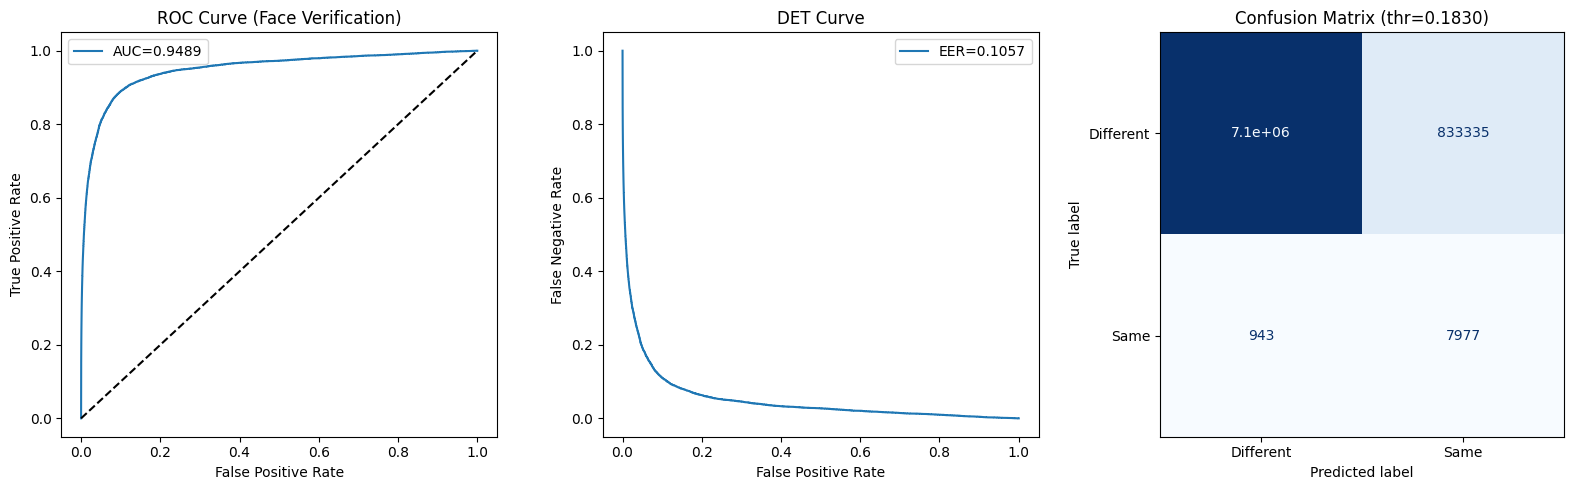

✅ ROC-AUC: 0.9489
✅ EER: 0.1057 (threshold=0.1830)
✅ TPR@FPR=1e-3: 0.2563
✅ Precision: 0.0095
✅ Recall: 0.8943
✅ F1-score: 0.0188
✅ Balanced Accuracy: 0.8943


In [43]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

metrics = evaluate_verification_plot(model, test_loader, device)

# Upload KaggleHub

In [20]:
!pip install kagglehub

In [21]:
import kagglehub

# Replace with path to directory containing model files.
LOCAL_MODEL_DIR = checkpoint_path

MODEL_SLUG = 'ArcFaceFR' # Replace with model slug.

# Learn more about naming model variations at
# https://www.kaggle.com/docs/models#name-model.
VARIATION_SLUG = 'default' # Replace with variation slug.

kagglehub.model_upload(
  handle = f"donhuyn/{MODEL_SLUG}/pyTorch/{VARIATION_SLUG}",
  local_model_dir = LOCAL_MODEL_DIR,
  version_notes = 'Update 2025-10-31')

Uploading Model https://www.kaggle.com/models/donhuyn/ArcFaceFR/pyTorch/default ...
Starting upload for file /kaggle/working/checkpoints/epoch_28.pt


Uploading: 100%|██████████| 341M/341M [00:03<00:00, 92.0MB/s] 

Upload successful: /kaggle/working/checkpoints/epoch_28.pt (325MB)


Your model instance version has been created.
Files are being processed...
See at: https://www.kaggle.com/models/donhuyn/ArcFaceFR/pyTorch/default
